# Omdena  - Milan Chapter Agrifoods
## AI for Sustainable agri-food systems: use of Satellite Imagery
### Exploratory analysis of industrial crop production in Italy 2006-2022
#### Author: Maria Fisher 


The main objective of this study is to have gather information about crop production in Italy for the period of 2006-2022. 

Crop dataset used in this study was downloaded from the Italian National Institute of Statistics (Istat).



In [20]:
import warnings 
warnings.filterwarnings("ignore")

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
import seaborn as sns 
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy 
import sklearn
import geopandas as gpd
import pgeocode
import folium
import sys
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot

In [21]:
industrial_crop = pd.read_csv('./Italy_crop_data/industrial_crop.csv',skipinitialspace=True)
industrial_crop.head()

,ITTER107,Territory,TIPO_DATO5,Data type,AGRI_MADRE,Type of crop,TIME,Select time,Value,Flag Codes,Flags
0,ITC16,Cuneo,TP_QUIN_EXT,total production - quintals,PARSNGREEN,parsley in greenhouses,2006,2006,750,e,estimate data
1,ITC16,Cuneo,TP_QUIN_EXT,total production - quintals,PARSNGREEN,parsley in greenhouses,2007,2007,780,NaN,NaN
2,ITC16,Cuneo,TP_QUIN_EXT,total production - quintals,PARSNGREEN,parsley in greenhouses,2008,2008,810,NaN,NaN
3,ITC16,Cuneo,TP_QUIN_EXT,total production - quintals,PARSNGREEN,parsley in greenhouses,2009,2009,773,e,estimate data
4,ITC16,Cuneo,TP_QUIN_EXT,total production - quintals,PARSNGREEN,parsley in greenhouses,2010,2010,788,e,estimate data


## Pre-processing dataset 

In [22]:
# Drop Columns
industrial_crop = industrial_crop.drop(columns =['ITTER107','TIPO_DATO5','AGRI_MADRE', 'TIME', 'Flag Codes','Flags' ])
industrial_crop

,Territory,Data type,Type of crop,Select time,Value
0,Cuneo,total production - quintals,parsley in greenhouses,2006,750
1,Cuneo,total production - quintals,parsley in greenhouses,2007,780
2,Cuneo,total production - quintals,parsley in greenhouses,2008,810
3,Cuneo,total production - quintals,parsley in greenhouses,2009,773
4,Cuneo,total production - quintals,parsley in greenhouses,2010,788
...,...,...,...,...,...
19180,Trentino Alto Adige / Südtirol,harvested production - quintals,hops,2021,60
19181,Grosseto,total area - hectares,other oilseed crops (excluding sesame),2021,72
19182,Udine,total area - hectares,hops,2021,1
19183,Arezzo,total area - hectares,other textile crops,2021,4


In [23]:
# Rename Columns
industrial_crop = industrial_crop.rename(columns = {'Select time':'Year', 'Type of crop':'Type_crop', 'Data type':'Data_type', 'Territory':'City'})


In [24]:
def show_info(industrial_crop):
    print('DATASET SHAPE: ', industrial_crop.shape, '\n')
    print('-'*50)
    print('FEATURE DATA TYPES:')
    print(industrial_crop.info())
    print('\n', '-'*50)
    print('NUMBER OF UNIQUE VALUES PER FEATURE:', '\n')
    print(industrial_crop.nunique())
    print('\n', '-'*50)
    print('NULL VALUES PER FEATURE')
    print(industrial_crop.isnull().sum())
show_info(industrial_crop)

DATASET SHAPE:  (19185, 5) 

--------------------------------------------------
FEATURE DATA TYPES:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19185 entries, 0 to 19184
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   City       19185 non-null  object
 1   Data_type  19185 non-null  object
 2   Type_crop  19185 non-null  object
 3   Year       19185 non-null  int64 
 4   Value      19185 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 749.5+ KB
None

 --------------------------------------------------
NUMBER OF UNIQUE VALUES PER FEATURE: 

City          108
Data_type       4
Type_crop      18
Year           17
Value        4025
dtype: int64

 --------------------------------------------------
NULL VALUES PER FEATURE
City         0
Data_type    0
Type_crop    0
Year         0
Value        0
dtype: int64


## Cities in Italy producing industrial crop

In [25]:
#industrial_crop.City.unique()


In [26]:
industrial_crop.Data_type.unique()

array(['total production - quintals ', 'harvested production - quintals ',
       'total area - ares', 'total area - hectares'], dtype=object)

## Select only Values for total industrial crop production - quintals


In [27]:
industrial_crop_prod = industrial_crop[industrial_crop['Data_type'] == 'total production - quintals ']
industrial_crop_prod.head()

,City,Data_type,Type_crop,Year,Value
0,Cuneo,total production - quintals,parsley in greenhouses,2006,750
1,Cuneo,total production - quintals,parsley in greenhouses,2007,780
2,Cuneo,total production - quintals,parsley in greenhouses,2008,810
3,Cuneo,total production - quintals,parsley in greenhouses,2009,773
4,Cuneo,total production - quintals,parsley in greenhouses,2010,788


In [28]:
industrial_crop_prod = industrial_crop_prod.rename(columns = {'Value':'Total_production'})
industrial_crop_prod

,City,Data_type,Type_crop,Year,Total_production
0,Cuneo,total production - quintals,parsley in greenhouses,2006,750
1,Cuneo,total production - quintals,parsley in greenhouses,2007,780
2,Cuneo,total production - quintals,parsley in greenhouses,2008,810
3,Cuneo,total production - quintals,parsley in greenhouses,2009,773
4,Cuneo,total production - quintals,parsley in greenhouses,2010,788
...,...,...,...,...,...
19137,Campobasso,total production - quintals,"other aromatic, medicinal and culinary plants",2021,150
19143,Reggio di Calabria,total production - quintals,"other aromatic, medicinal and culinary plants",2021,95
19144,Caserta,total production - quintals,"other aromatic, medicinal and culinary plants",2021,33520
19177,Trentino Alto Adige / Südtirol,total production - quintals,hops,2020,50


In [29]:
industrial_crop_prod = industrial_crop_prod.drop(columns =['Data_type'])
industrial_crop_prod

,City,Type_crop,Year,Total_production
0,Cuneo,parsley in greenhouses,2006,750
1,Cuneo,parsley in greenhouses,2007,780
2,Cuneo,parsley in greenhouses,2008,810
3,Cuneo,parsley in greenhouses,2009,773
4,Cuneo,parsley in greenhouses,2010,788
...,...,...,...,...
19137,Campobasso,"other aromatic, medicinal and culinary plants",2021,150
19143,Reggio di Calabria,"other aromatic, medicinal and culinary plants",2021,95
19144,Caserta,"other aromatic, medicinal and culinary plants",2021,33520
19177,Trentino Alto Adige / Südtirol,hops,2020,50


## Total industrial crop production in 2006-2022

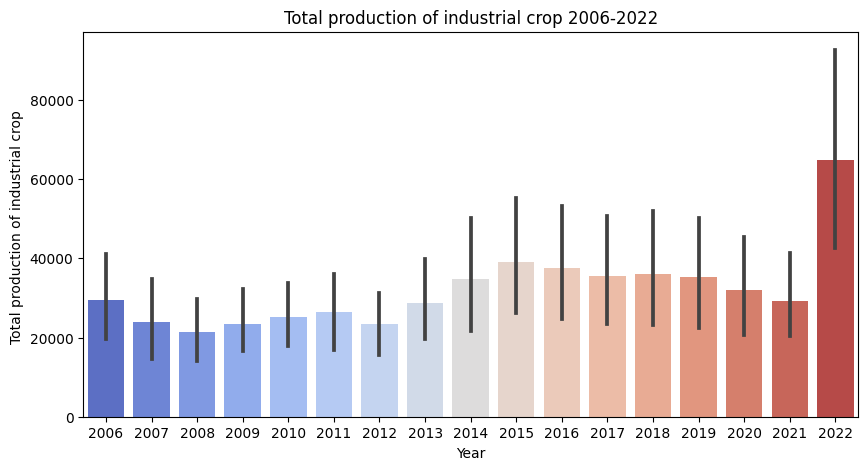

In [30]:
plt.figure(figsize= (10,5))
sns.barplot(x= 'Year', y= 'Total_production',data = industrial_crop_prod, palette='coolwarm')
plt.title('Total production of industrial crop 2006-2022')
plt.xlabel('Year')
plt.ylabel('Total production of industrial crop ')
plt.show()



## Industrial crop production by Cities 

In [31]:
industrial_crop_prod_region = industrial_crop_prod.groupby(by = industrial_crop_prod.City)['Total_production','City'].sum().reset_index().sort_values(by = 'Total_production', ascending = False)
industrial_crop_prod_region



,City,Total_production
101,Venezia,20505093
98,Udine,15186769
83,Rovigo,14010138
31,Ferrara,12469830
63,Padova,11058704
...,...,...
42,La Spezia,447
60,Ogliastra,283
61,Olbia-Tempio,109
29,Enna,94


In [32]:
region = industrial_crop_prod_region.nlargest(30, 'Total_production')

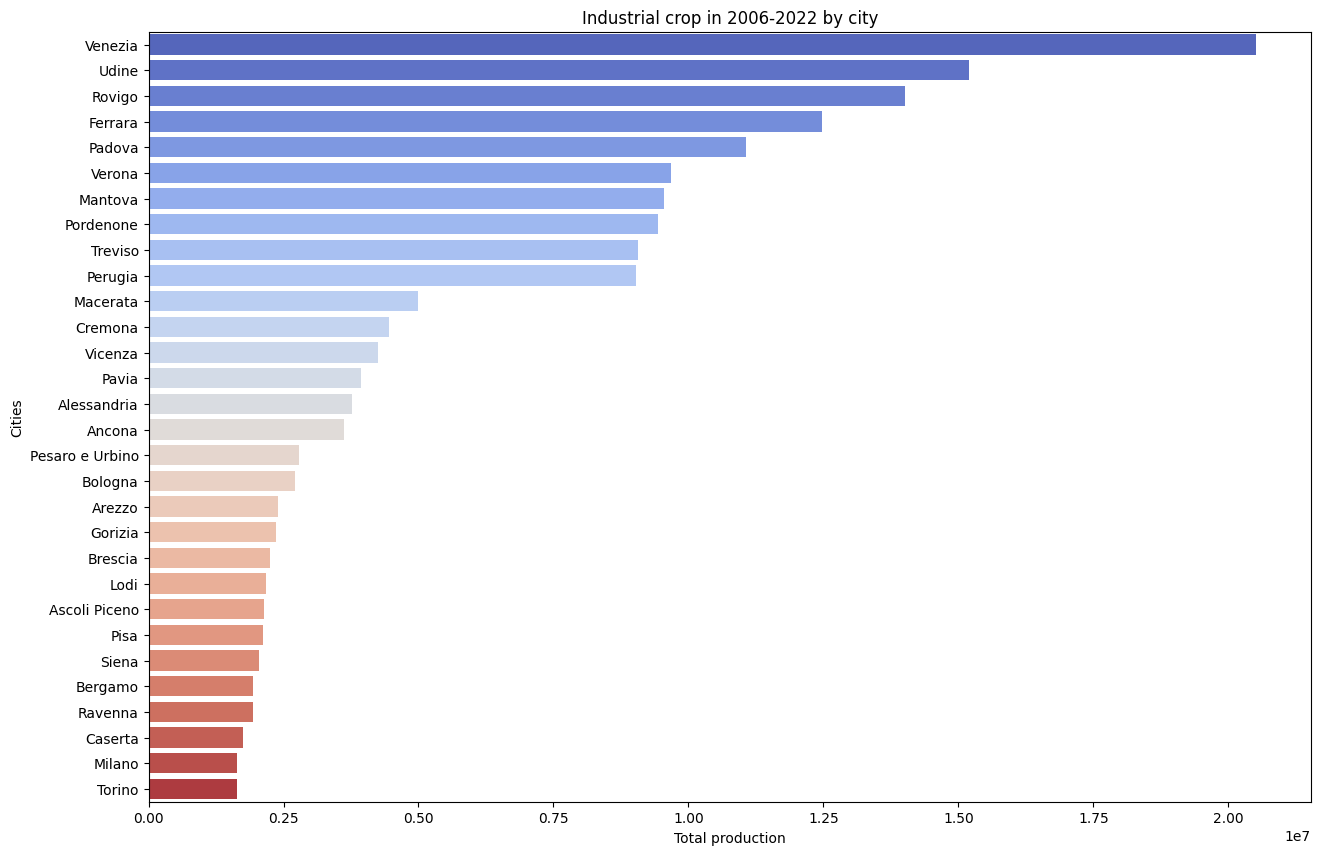

In [33]:
plt.figure(figsize= (15, 10))
sns.barplot(x= region['Total_production'],y= region['City'], orient='h', palette='coolwarm');
plt.title('Industrial crop in 2006-2022 by city')
plt.xlabel('Total production')
plt.ylabel('Cities')
plt.show() 

##  Industrial crop  2020-2022

In [34]:
print(industrial_crop_prod.Type_crop.max())
print(industrial_crop_prod.Type_crop.value_counts())
print(industrial_crop_prod.Type_crop.nunique())



valerian in greenhouses
sunflower                                        1204
rape                                             1023
soya beans                                        986
sweet basil in greenhouses                        654
parsley in open field                             624
parsley in greenhouses                            585
tobacco                                           352
valerian in greenhouses                           327
hemp                                              320
flax                                              127
turnip rape                                        77
groundnut                                          51
hops                                               33
sesame                                              8
other aromatic, medicinal and culinary plants       8
cotton                                              5
other textile crops                                 2
other oilseed crops (excluding sesame)              1
Name

Dataset shows there are 17 different types of industrial crop cultivated in Italy. The top most produced crops are : Valerian, Greenhouses, Sunflower, Rape, Soya beans, Hemp, Parsley in open field, Sweet basil in greenhouses, Parsley in greenhouses, Tobacco, Flax. 


In [38]:
industrial_crop_prod.describe()

,Year,Total_production
count,6387.000000,6.387000e+03
mean,2014.166902,3.153793e+04
std,4.763694,1.241813e+05
min,2006.000000,0.000000e+00
25%,2010.000000,2.400000e+02
50%,2014.000000,1.500000e+03
75%,2018.000000,9.300000e+03
max,2022.000000,1.739780e+06


In [41]:
industrial_crop_prod = industrial_crop_prod.replace('valerian in greenhouses','valerian-ghouse')
industrial_crop_prod = industrial_crop_prod.replace('sweet basil in greenhouses','basil-ghouse')
industrial_crop_prod = industrial_crop_prod.replace('other aromatic, medicinal and culinary plants','aromatic-medicinal')
industrial_crop_prod = industrial_crop_prod.replace('parsley in greenhouses','parsley-ghouse')
industrial_crop_prod = industrial_crop_prod.replace('parsley in open field','parsley-field')
industrial_crop_prod = industrial_crop_prod.replace('other oilseed crops (excluding sesame)','oilseeds(No-sesame)')
industrial_crop_prod = industrial_crop_prod.replace('other textile crops','textile-crops')

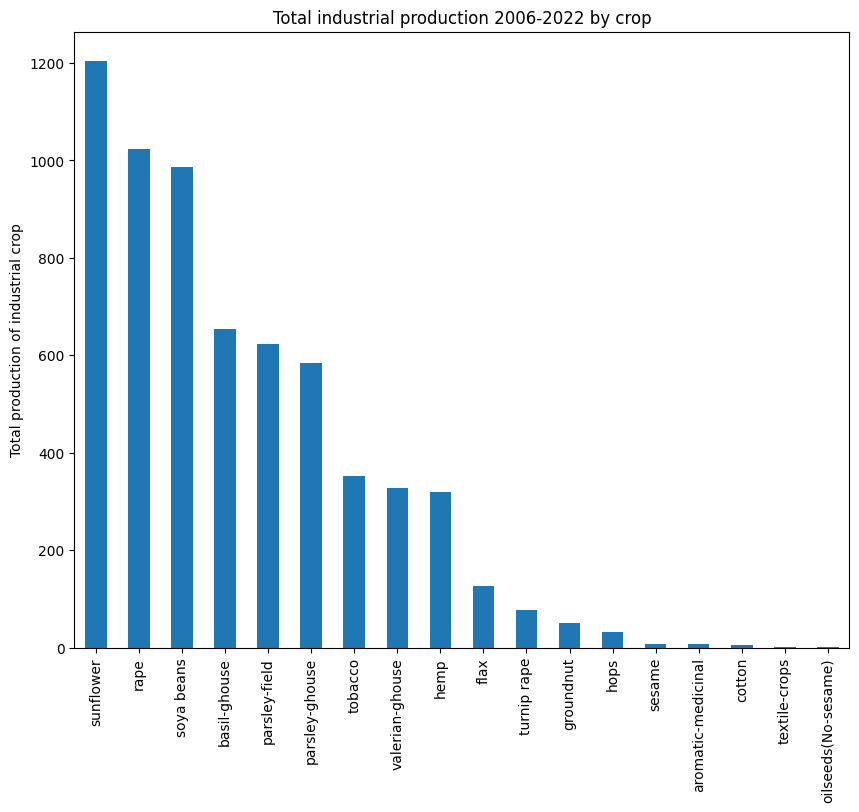

In [42]:
plt.figure(figsize=(10,8))
industrial_crop_prod ['Type_crop'].value_counts().plot.bar()
plt.title('Total industrial production 2006-2022 by crop')
plt.ylabel('Total production of industrial crop')
plt.show()


## Subseting data

In [46]:
industrial_crop_top10 = industrial_crop_prod.apply(lambda row: row[industrial_crop_prod['Type_crop'].isin(['valerian-ghouse', 'basil-ghouse', 'sunflower', 'rape', 
                                                                                                           'soya beans', 'hemp', 'parsley-field', 
                                                                                                           'parsley-ghouse', 'tobacco', 'flax'])])

industrial_crop_top10.head()

,City,Type_crop,Year,Total_production
0,Cuneo,parsley-ghouse,2006,750
1,Cuneo,parsley-ghouse,2007,780
2,Cuneo,parsley-ghouse,2008,810
3,Cuneo,parsley-ghouse,2009,773
4,Cuneo,parsley-ghouse,2010,788


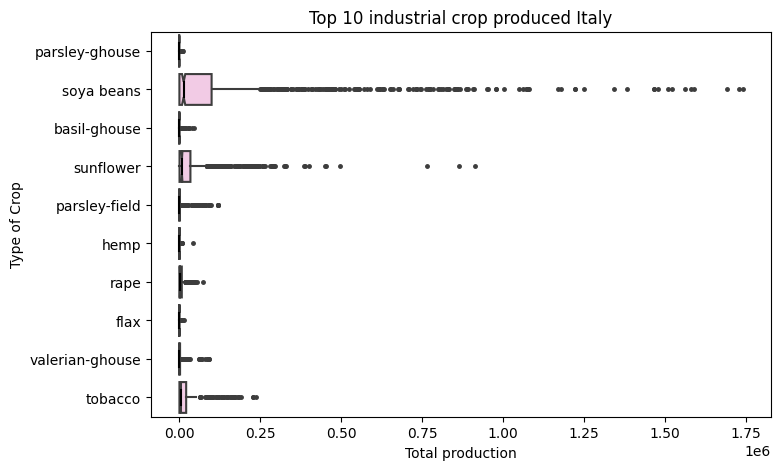

In [47]:
plt.figure(figsize=(8,5))

sns.boxplot(
    data=industrial_crop_top10, y="Type_crop", x="Total_production",
    notch=True, showcaps=False,
    flierprops={"marker": "."},
    boxprops={"facecolor": (.9, .6, .8, .5)},
    medianprops={"color": "black"},
)
plt.title('Top 10 industrial crop produced Italy')
plt.ylabel('Type of Crop')
plt.xlabel('Total production')
plt.show()

In [48]:
industrial_crop_top10

,City,Type_crop,Year,Total_production
0,Cuneo,parsley-ghouse,2006,750
1,Cuneo,parsley-ghouse,2007,780
2,Cuneo,parsley-ghouse,2008,810
3,Cuneo,parsley-ghouse,2009,773
4,Cuneo,parsley-ghouse,2010,788
...,...,...,...,...
19044,La Spezia,tobacco,2019,447
19045,Gorizia,tobacco,2019,537
19046,Sud Sardegna,parsley-ghouse,2020,1461
19047,Sud Sardegna,parsley-ghouse,2021,1461


## Vizualization of ten type of industrial crop produced in Italy in the period of 2006-2022 

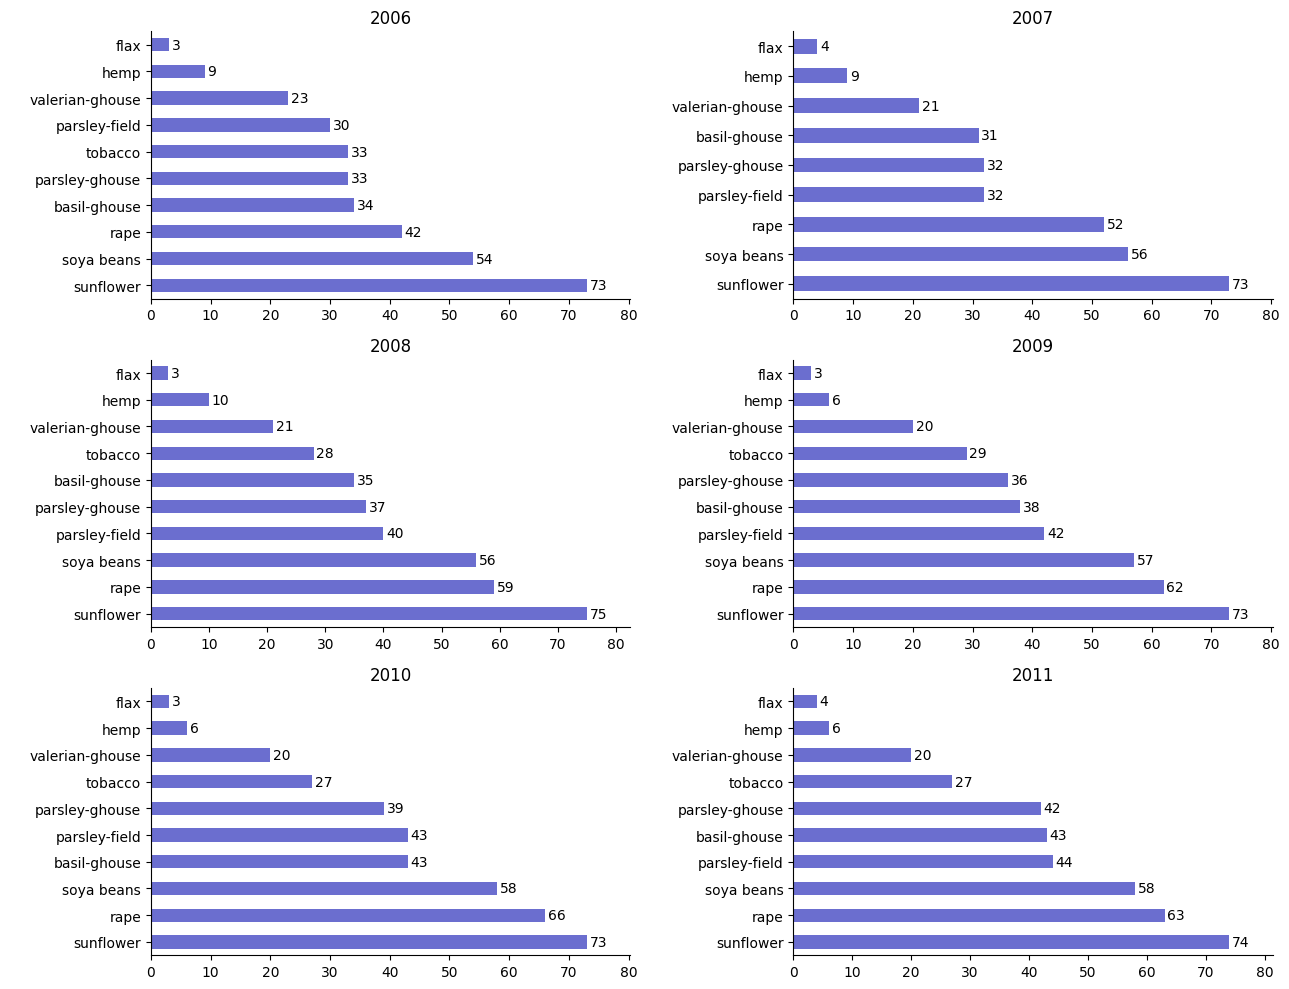

In [49]:
fig, axs = plt.subplots(3,2, figsize=(13, 10))
plt.ylabel(" ")

plot1 = industrial_crop_top10[industrial_crop_top10.Year == 2006].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#6b6ecf', title='2006', ax=axs[0,0])
plot2 = industrial_crop_top10[industrial_crop_top10.Year == 2007].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#6b6ecf', title='2007', ax=axs[0,1])
plot3 = industrial_crop_top10[industrial_crop_top10.Year == 2008].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#6b6ecf', title='2008', ax=axs[1,0])
plot4 = industrial_crop_top10[industrial_crop_top10.Year == 2009].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#6b6ecf', title='2009', ax=axs[1,1])
plot5 = industrial_crop_top10[industrial_crop_top10.Year == 2010].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#6b6ecf', title='2010', ax=axs[2,0])
plot6 = industrial_crop_top10[industrial_crop_top10.Year == 2011].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#6b6ecf', title='2011', ax=axs[2,1])

for ax in axs.flat:
    ax.bar_label(ax.containers[0], fmt='%.0f', label_type='edge', padding=2)
    ax.margins(x=0.1)
    ax.set_ylabel(' ')
    sns.despine()

plt.tight_layout()
plt.show()



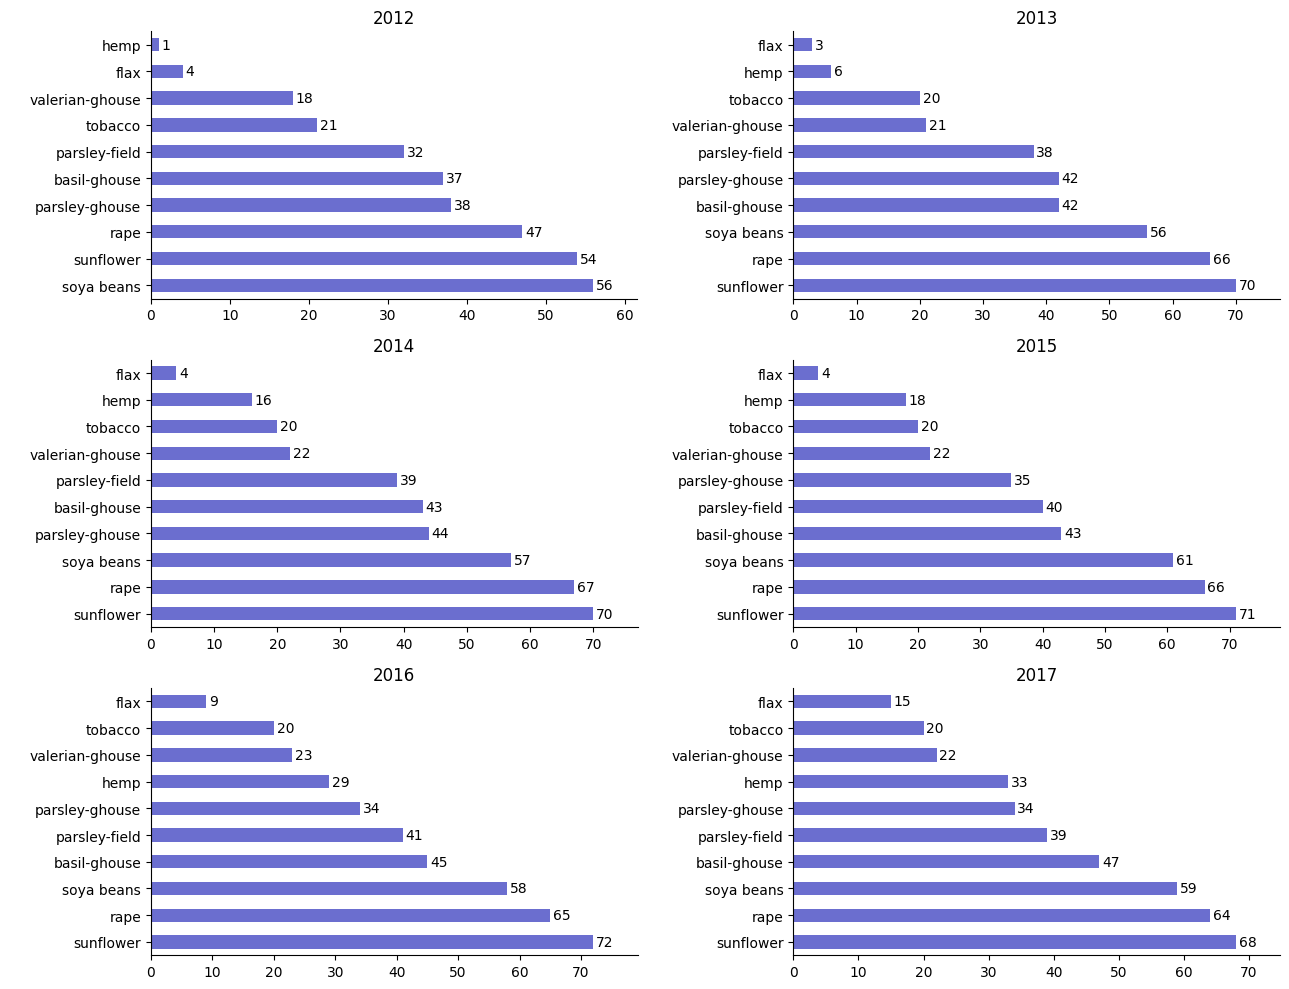

In [50]:
fig, axs = plt.subplots(3,2, figsize=(13, 10))


plot7 = industrial_crop_top10[industrial_crop_top10.Year == 2012].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#6b6ecf', title='2012', ax=axs[0,0])
plot8 = industrial_crop_top10[industrial_crop_top10.Year == 2013].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#6b6ecf', title='2013', ax=axs[0,1])
plot9 = industrial_crop_top10[industrial_crop_top10.Year == 2014].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#6b6ecf', title='2014', ax=axs[1,0])
plot10 = industrial_crop_top10[industrial_crop_top10.Year == 2015].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#6b6ecf', title='2015', ax=axs[1,1])
plot11 = industrial_crop_top10[industrial_crop_top10.Year == 2016].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#6b6ecf', title='2016', ax=axs[2,0])
plot12 = industrial_crop_top10[industrial_crop_top10.Year == 2017].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#6b6ecf', title='2017', ax=axs[2,1])

for ax in axs.flat:
    ax.bar_label(ax.containers[0], fmt='%.0f', label_type='edge', padding=2)
    ax.margins(x=0.1)
    ax.set_ylabel(' ')
    sns.despine()
    
plt.tight_layout()
plt.show()

IndexError: list index out of range

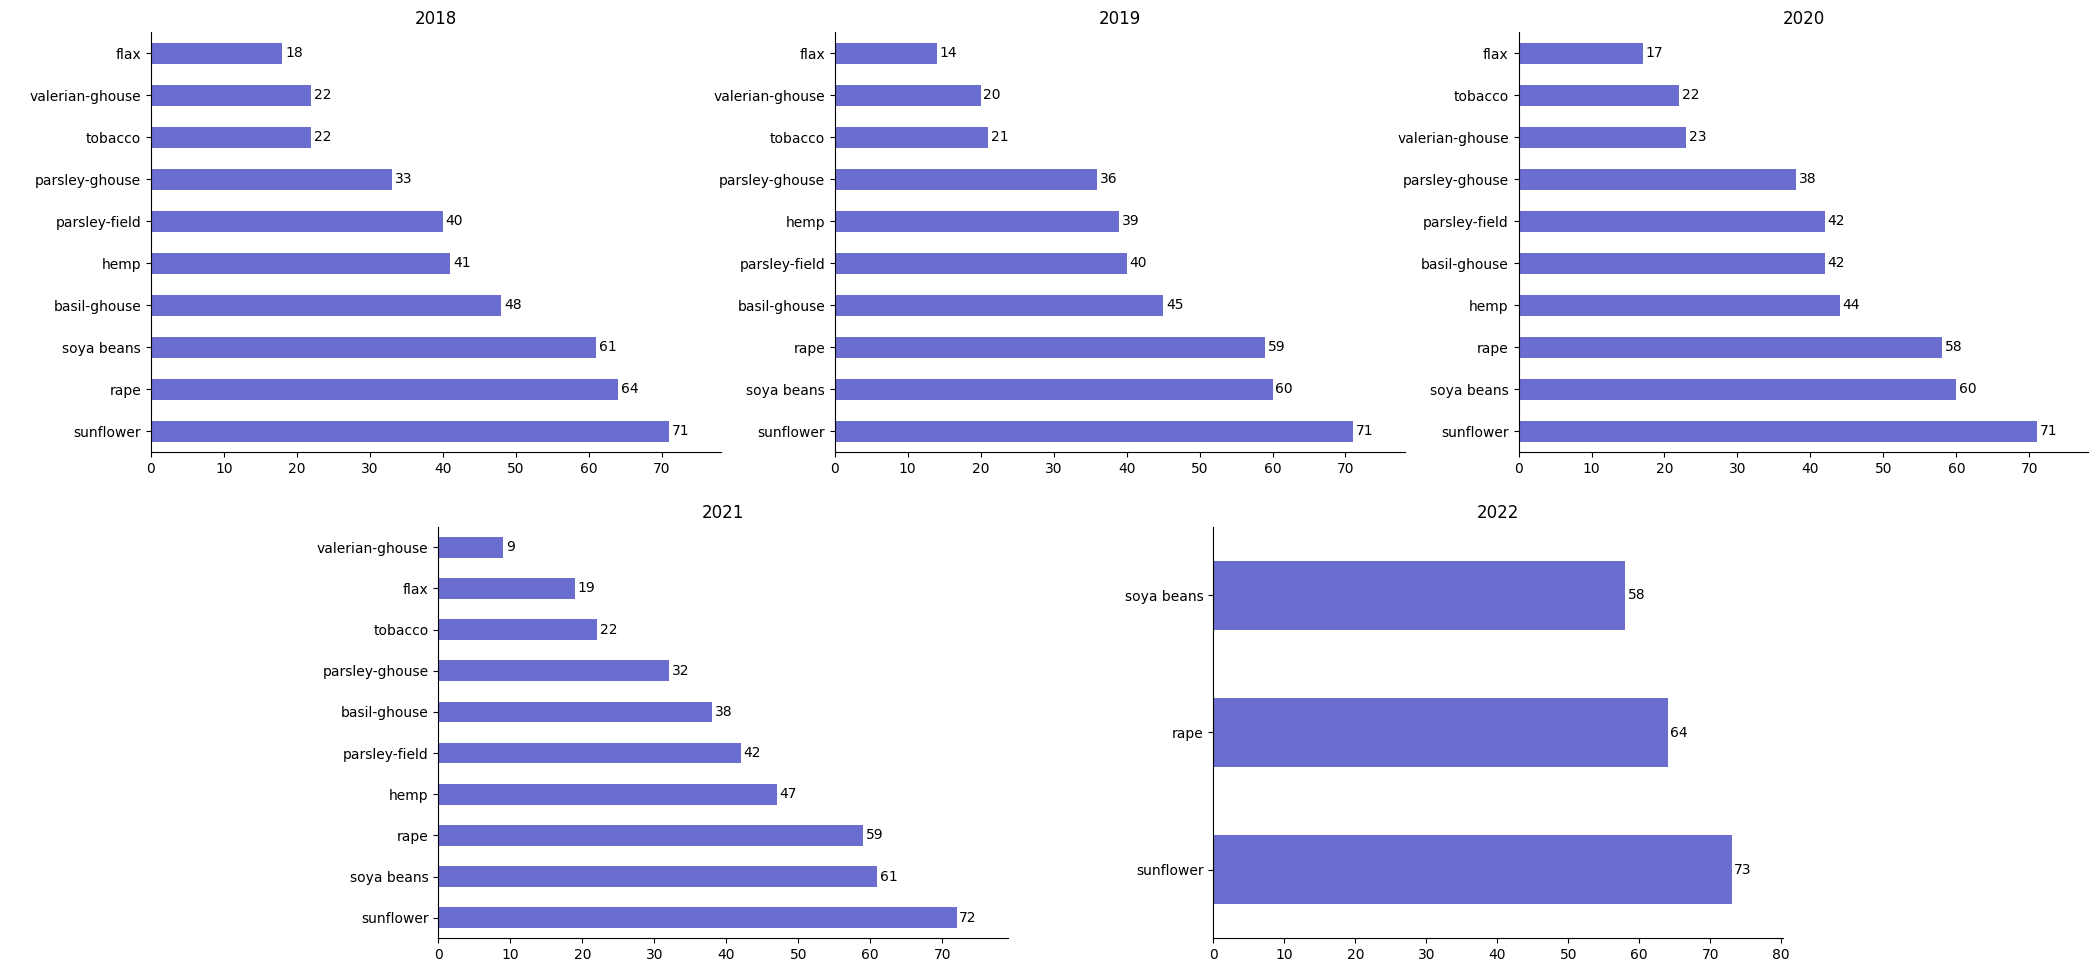

In [51]:
fig, axs = plt.subplots(2,3, figsize=(25,12))

axs[1,0].set_position([0.24,0.125,0.228,0.343])
axs[1,1].set_position([0.55,0.125,0.228,0.343])
axs[1,2].set_visible(False)

plot13 = industrial_crop_top10[industrial_crop_top10.Year == 2018].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#6b6ecf', title='2018', ax=axs[0,0])
plot14 = industrial_crop_top10[industrial_crop_top10.Year == 2019].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#6b6ecf', title='2019', ax=axs[0,1])
plot15 = industrial_crop_top10[industrial_crop_top10.Year == 2020].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#6b6ecf', title='2020', ax=axs[0,2])
plot16 = industrial_crop_top10[industrial_crop_top10.Year == 2021].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#6b6ecf', title='2021', ax=axs[1,0])
plot17 = industrial_crop_top10[industrial_crop_top10.Year == 2022].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#6b6ecf', title='2022', ax=axs[1,1])

for ax in axs.flat:
    ax.bar_label(ax.containers[0], fmt='%.0f', label_type='edge', padding=2)
    ax.margins(x=0.1)
    ax.set_ylabel(' ')
    sns.despine()

plt.tight_layout()

plt.show()


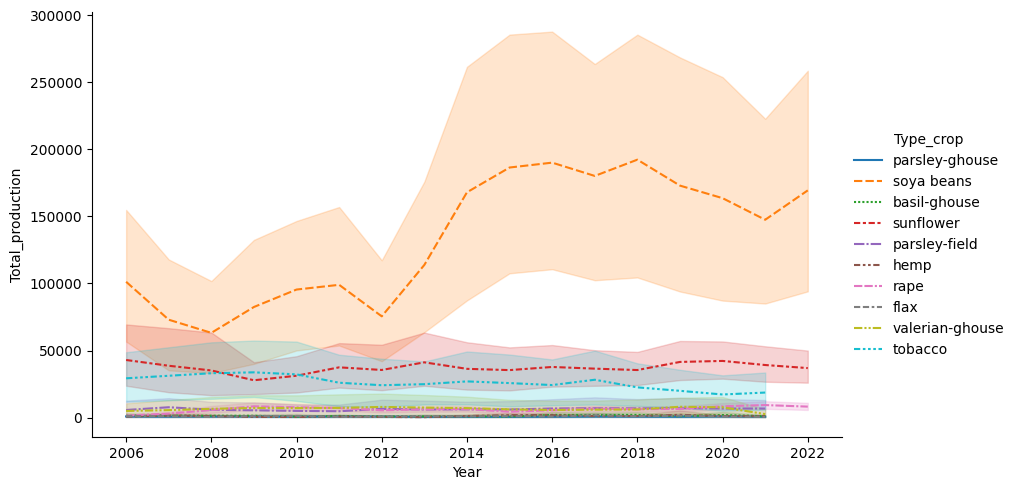

In [52]:
#Crop harvested by year
plotcrop10 = sns.relplot(kind='line', data=industrial_crop_top10, x='Year', y='Total_production', hue='Type_crop', style='Type_crop', aspect=1.75)


In [ ]:
# Select year 2020 for future join with fertilizer
industrial_crop_top10 = industrial_crop_top10[industrial_crop_top10['Year'] == 2020]
industrial_crop_top10



### Create columns for each type crop 

In [53]:
# Create columns for each type crop
industrial_crop_top10_pivot = industrial_crop_top10.pivot_table(index=['City', 'Year'],aggfunc='sum', columns='Type_crop',values=['Total_production'])
industrial_crop_top10_pivot

Total_production                                              \
Type_crop          basil-ghouse    flax   hemp parsley-field parsley-ghouse   
City      Year                                                                
Agrigento 2006              NaN     NaN    NaN          50.0            NaN   
          2007              NaN     NaN    NaN          90.0            NaN   
          2008              NaN     NaN    NaN          88.0            NaN   
          2009              NaN     NaN    NaN          84.0            NaN   
          2010              NaN     NaN    NaN          97.0            NaN   
...                         ...     ...    ...           ...            ...   
Viterbo   2018              NaN  1000.0  480.0           NaN            NaN   
          2019              NaN  1150.0  165.0           NaN            NaN   
          2020              NaN  1150.0  215.0           NaN            NaN   
          2021              NaN  1140.0  215.0           NaN            NaN   
          2022              NaN     NaN    NaN           NaN            NaN   

                                                                    
Type_crop        rape soya beans sunflower tobacco valerian-ghouse  
City      Year                                                      
Agrigento 2006    NaN        NaN       NaN     NaN             NaN  
          2007    NaN        NaN       NaN     NaN             NaN  
          2008    NaN        NaN       NaN     NaN             NaN  
          2009    NaN        NaN       NaN     NaN             NaN  
          2010    NaN        NaN       NaN     NaN             NaN  
...               ...        ...       ...     ...             ...  
Viterbo   2018  420.0        NaN   18000.0  6352.0             NaN  
          2019  600.0        NaN   18000.0  7500.0             NaN  
          2020  550.0        NaN   16900.0  2699.0             NaN  
          2021  290.0        NaN   16760.0  3234.0             NaN  
          2022  280.0        NaN   16930.0     NaN             NaN  

[1639 rows x 10 columns]

In [54]:
# Drop level
industrial_crop_top10_pivot.columns = industrial_crop_top10_pivot.columns.droplevel()
industrial_crop_top10_pivot

Type_crop       basil-ghouse    flax   hemp  parsley-field  parsley-ghouse  \
City      Year                                                               
Agrigento 2006           NaN     NaN    NaN           50.0             NaN   
          2007           NaN     NaN    NaN           90.0             NaN   
          2008           NaN     NaN    NaN           88.0             NaN   
          2009           NaN     NaN    NaN           84.0             NaN   
          2010           NaN     NaN    NaN           97.0             NaN   
...                      ...     ...    ...            ...             ...   
Viterbo   2018           NaN  1000.0  480.0            NaN             NaN   
          2019           NaN  1150.0  165.0            NaN             NaN   
          2020           NaN  1150.0  215.0            NaN             NaN   
          2021           NaN  1140.0  215.0            NaN             NaN   
          2022           NaN     NaN    NaN            NaN             NaN   

Type_crop        rape  soya beans  sunflower  tobacco  valerian-ghouse  
City      Year                                                          
Agrigento 2006    NaN         NaN        NaN      NaN              NaN  
          2007    NaN         NaN        NaN      NaN              NaN  
          2008    NaN         NaN        NaN      NaN              NaN  
          2009    NaN         NaN        NaN      NaN              NaN  
          2010    NaN         NaN        NaN      NaN              NaN  
...               ...         ...        ...      ...              ...  
Viterbo   2018  420.0         NaN    18000.0   6352.0              NaN  
          2019  600.0         NaN    18000.0   7500.0              NaN  
          2020  550.0         NaN    16900.0   2699.0              NaN  
          2021  290.0         NaN    16760.0   3234.0              NaN  
          2022  280.0         NaN    16930.0      NaN              NaN  

[1639 rows x 10 columns]

In [55]:
industrial_crop_top10_pivot = industrial_crop_top10_pivot.fillna(0)
industrial_crop_top10_pivot

Type_crop       basil-ghouse    flax   hemp  parsley-field  parsley-ghouse  \
City      Year                                                               
Agrigento 2006           0.0     0.0    0.0           50.0             0.0   
          2007           0.0     0.0    0.0           90.0             0.0   
          2008           0.0     0.0    0.0           88.0             0.0   
          2009           0.0     0.0    0.0           84.0             0.0   
          2010           0.0     0.0    0.0           97.0             0.0   
...                      ...     ...    ...            ...             ...   
Viterbo   2018           0.0  1000.0  480.0            0.0             0.0   
          2019           0.0  1150.0  165.0            0.0             0.0   
          2020           0.0  1150.0  215.0            0.0             0.0   
          2021           0.0  1140.0  215.0            0.0             0.0   
          2022           0.0     0.0    0.0            0.0             0.0   

Type_crop        rape  soya beans  sunflower  tobacco  valerian-ghouse  
City      Year                                                          
Agrigento 2006    0.0         0.0        0.0      0.0              0.0  
          2007    0.0         0.0        0.0      0.0              0.0  
          2008    0.0         0.0        0.0      0.0              0.0  
          2009    0.0         0.0        0.0      0.0              0.0  
          2010    0.0         0.0        0.0      0.0              0.0  
...               ...         ...        ...      ...              ...  
Viterbo   2018  420.0         0.0    18000.0   6352.0              0.0  
          2019  600.0         0.0    18000.0   7500.0              0.0  
          2020  550.0         0.0    16900.0   2699.0              0.0  
          2021  290.0         0.0    16760.0   3234.0              0.0  
          2022  280.0         0.0    16930.0      0.0              0.0  

[1639 rows x 10 columns]

In [56]:
#Rename index
industrial_crop_top10_pivot = industrial_crop_top10_pivot.rename_axis(None,axis=1)
industrial_crop_top10_pivot

basil-ghouse    flax   hemp  parsley-field  parsley-ghouse  \
City      Year                                                               
Agrigento 2006           0.0     0.0    0.0           50.0             0.0   
          2007           0.0     0.0    0.0           90.0             0.0   
          2008           0.0     0.0    0.0           88.0             0.0   
          2009           0.0     0.0    0.0           84.0             0.0   
          2010           0.0     0.0    0.0           97.0             0.0   
...                      ...     ...    ...            ...             ...   
Viterbo   2018           0.0  1000.0  480.0            0.0             0.0   
          2019           0.0  1150.0  165.0            0.0             0.0   
          2020           0.0  1150.0  215.0            0.0             0.0   
          2021           0.0  1140.0  215.0            0.0             0.0   
          2022           0.0     0.0    0.0            0.0             0.0   

                 rape  soya beans  sunflower  tobacco  valerian-ghouse  
City      Year                                                          
Agrigento 2006    0.0         0.0        0.0      0.0              0.0  
          2007    0.0         0.0        0.0      0.0              0.0  
          2008    0.0         0.0        0.0      0.0              0.0  
          2009    0.0         0.0        0.0      0.0              0.0  
          2010    0.0         0.0        0.0      0.0              0.0  
...               ...         ...        ...      ...              ...  
Viterbo   2018  420.0         0.0    18000.0   6352.0              0.0  
          2019  600.0         0.0    18000.0   7500.0              0.0  
          2020  550.0         0.0    16900.0   2699.0              0.0  
          2021  290.0         0.0    16760.0   3234.0              0.0  
          2022  280.0         0.0    16930.0      0.0              0.0  

[1639 rows x 10 columns]

In [57]:
# Reset index
industrial_crop_top10_pivot = industrial_crop_top10_pivot.reset_index()
industrial_crop_top10_pivot

,City,Year,basil-ghouse,flax,hemp,parsley-field,parsley-ghouse,rape,soya beans,sunflower,tobacco,valerian-ghouse
0,Agrigento,2006,0.0,0.0,0.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Agrigento,2007,0.0,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Agrigento,2008,0.0,0.0,0.0,88.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Agrigento,2009,0.0,0.0,0.0,84.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Agrigento,2010,0.0,0.0,0.0,97.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1634,Viterbo,2018,0.0,1000.0,480.0,0.0,0.0,420.0,0.0,18000.0,6352.0,0.0
1635,Viterbo,2019,0.0,1150.0,165.0,0.0,0.0,600.0,0.0,18000.0,7500.0,0.0
1636,Viterbo,2020,0.0,1150.0,215.0,0.0,0.0,550.0,0.0,16900.0,2699.0,0.0
1637,Viterbo,2021,0.0,1140.0,215.0,0.0,0.0,290.0,0.0,16760.0,3234.0,0.0


## Estatistical analysis

In [58]:
industrial_crop_top10_pivot.describe()

,Year,basil-ghouse,flax,hemp,parsley-field,parsley-ghouse,rape,soya beans,sunflower,tobacco,valerian-ghouse
count,1639.000000,1639.000000,1639.000000,1639.000000,1639.000000,1639.000000,1639.000000,1.639000e+03,1639.000000,1639.000000,1639.000000
mean,2013.938377,515.365467,74.495424,243.884076,2363.994509,241.133618,3962.270897,8.118330e+04,27268.346553,5642.731544,1302.411836
std,4.834803,2413.839927,586.068839,1337.755148,11546.000945,897.509443,7479.055645,2.266830e+05,65926.723771,24737.650022,7923.887913
min,2006.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,2010.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
50%,2014.000000,0.000000,0.000000,0.000000,0.000000,0.000000,560.000000,4.050000e+02,2265.000000,0.000000,0.000000
75%,2018.000000,145.000000,0.000000,0.000000,350.000000,54.000000,4494.000000,2.973500e+04,21342.500000,0.000000,0.000000
max,2022.000000,45309.000000,14220.000000,43200.000000,121000.000000,11000.000000,72800.000000,1.739780e+06,912500.000000,238524.000000,92500.000000


#### Data metrics : skew, kurtosis and mode

In [61]:
industrial_crop_top10_pivot_stats = industrial_crop_top10_pivot[['valerian-ghouse', 'basil-ghouse', 'sunflower', 'rape', 
                                                                 'soya beans', 'hemp', 'parsley-field','parsley-ghouse',
                                                                 'tobacco', 'flax']]
print(industrial_crop_top10_pivot_stats.astype(float).skew())
print(industrial_crop_top10_pivot_stats.astype(float).kurtosis())
print(industrial_crop_top10_pivot_stats.astype(float).mode())


valerian-ghouse     8.996809
basil-ghouse       11.795085
sunflower           5.728801
rape                3.156631
soya beans          4.028683
hemp               21.495208
parsley-field       7.337270
parsley-ghouse      7.023877
tobacco             5.788282
flax               15.890429
dtype: float64
valerian-ghouse     87.306668
basil-ghouse       173.603866
sunflower           52.235686
rape                13.139997
soya beans          18.300919
hemp               653.946959
parsley-field       59.143380
parsley-ghouse      59.644276
tobacco             35.881935
flax               322.285591
dtype: float64
   valerian-ghouse  basil-ghouse  sunflower  rape  soya beans  hemp  \
0              0.0           0.0        0.0   0.0         0.0   0.0   

   parsley-field  parsley-ghouse  tobacco  flax  
0            0.0             0.0      0.0   0.0  


## Graphs

#### Histogram and Boxplot showing data distribuion and outliers¶
 
Normalizing the dataset

The data need to be normalized for further use in a modelling. Here the data will be normalize by deleting outliers using the interquartile range (IQR).

Calculate and print the interquartile range

In [63]:
Q1 = industrial_crop_top10_pivot_stats.quantile(0.25)
Q3 = industrial_crop_top10_pivot_stats.quantile(0.75)
IQR = Q3 - Q1
print(IQR)


valerian-ghouse        0.0
basil-ghouse         145.0
sunflower          21342.5
rape                4494.0
soya beans         29735.0
hemp                   0.0
parsley-field        350.0
parsley-ghouse        54.0
tobacco                0.0
flax                   0.0
dtype: float64


### Remove outliers and plot graphs

In [66]:
# Remove outliers
industrial_crop_top10_pivot_stats[~((industrial_crop_top10_pivot < (Q1 - 1.5 * IQR)) | (industrial_crop_top10_pivot_stats > (Q3 + 1.5 * IQR))).any(axis=1)]
print(industrial_crop_top10_pivot.shape)

(1639, 12)


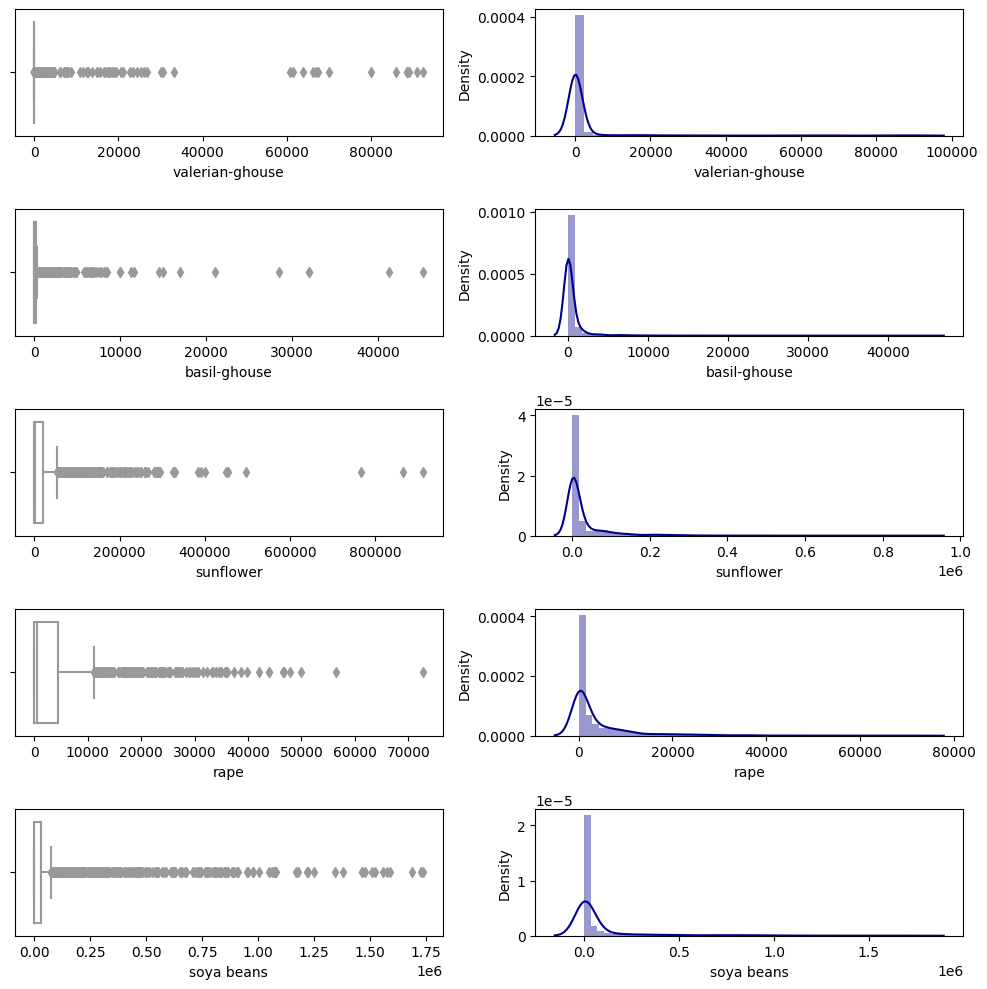

In [67]:
fig, ax = plt.subplots(5, 2, figsize = (10, 10))
sns.boxplot(x= industrial_crop_top10_pivot_stats["valerian-ghouse"], color = 'white', ax = ax[0,0])
sns.distplot(industrial_crop_top10_pivot_stats['valerian-ghouse'], color = 'darkblue', ax = ax[0,1])
sns.boxplot(x= industrial_crop_top10_pivot_stats["basil-ghouse"],color = 'white', ax = ax[1,0])
sns.distplot(industrial_crop_top10_pivot_stats['basil-ghouse'], color = 'darkblue', ax = ax[1,1])
sns.boxplot(x= industrial_crop_top10_pivot_stats["sunflower"],color = 'white', ax = ax[2,0])
sns.distplot(industrial_crop_top10_pivot_stats['sunflower'], color = 'darkblue',ax = ax[2,1])
sns.boxplot(x= industrial_crop_top10_pivot_stats["rape"], color = 'white', ax = ax[3,0])
sns.distplot(industrial_crop_top10_pivot_stats['rape'], color = 'darkblue', ax = ax[3,1])
sns.boxplot(x= industrial_crop_top10_pivot_stats["soya beans"], color = 'white',ax = ax[4,0])
sns.distplot(industrial_crop_top10_pivot_stats['soya beans'], color = 'darkblue',ax = ax[4,1])

plt.tight_layout()

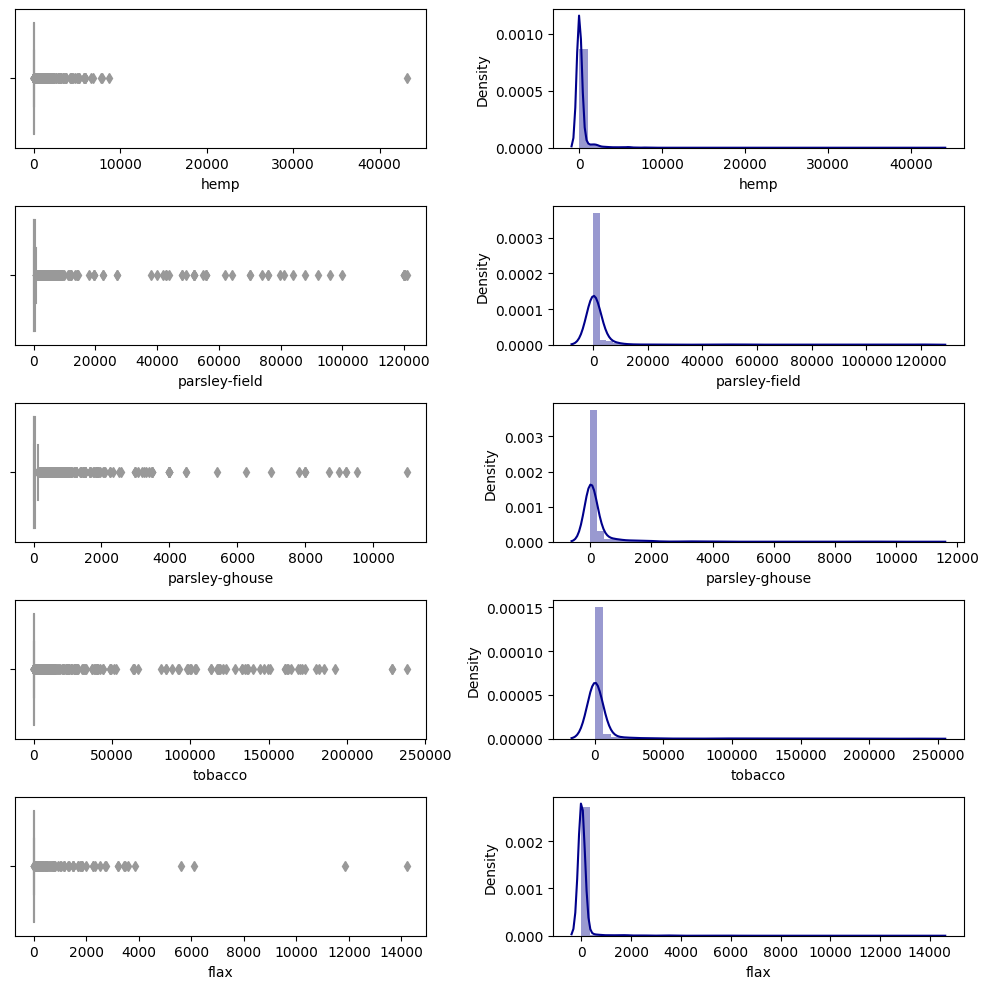

In [68]:
fig, ax = plt.subplots(5, 2, figsize = (10, 10))
sns.boxplot(x= industrial_crop_top10_pivot_stats["hemp"], color = 'white', ax = ax[0,0])
sns.distplot(industrial_crop_top10_pivot_stats['hemp'], color = 'darkblue', ax = ax[0,1])
sns.boxplot(x= industrial_crop_top10_pivot_stats["parsley-field"],color = 'white', ax = ax[1,0])
sns.distplot(industrial_crop_top10_pivot_stats['parsley-field'], color = 'darkblue', ax = ax[1,1])
sns.boxplot(x= industrial_crop_top10_pivot_stats["parsley-ghouse"],color = 'white', ax = ax[2,0])
sns.distplot(industrial_crop_top10_pivot_stats['parsley-ghouse'], color = 'darkblue',ax = ax[2,1])
sns.boxplot(x= industrial_crop_top10_pivot_stats["tobacco"], color = 'white',ax = ax[3,0])
sns.distplot(industrial_crop_top10_pivot_stats['tobacco'], color = 'darkblue',ax = ax[3,1])
sns.boxplot(x= industrial_crop_top10_pivot_stats["flax"], color = 'white',ax = ax[4,0])
sns.distplot(industrial_crop_top10_pivot_stats['flax'], color = 'darkblue',ax = ax[4,1])

plt.tight_layout()

## Pre-processing ferlizers dataset

fertilizers distributed - tonnes


In [70]:
fertilizer = pd.read_csv('fertilizer_by_prov.csv',skipinitialspace=True)
fertilizer.head()

,ITTER107,Territory,TIPO_DATO5,Data type,FERTILIZZANTI,Type of fertilizer,TIME,Select time,Value,Flag Codes,Flags
0,ITC11,Torino,FERT_DISTRIB_Q,fertilizers distributed - quintals,AZOTATI_CALCIO,calcium cyanamide,2006,2006,1227,NaN,NaN
1,ITC11,Torino,FERT_DISTRIB_Q,fertilizers distributed - quintals,AZOTATI_CALCIO,calcium cyanamide,2007,2007,1812,NaN,NaN
2,ITC11,Torino,FERT_DISTRIB_Q,fertilizers distributed - quintals,AZOTATI_CALCIO,calcium cyanamide,2008,2008,5224,NaN,NaN
3,ITC11,Torino,FERT_DISTRIB_Q,fertilizers distributed - quintals,AZOTATI_CALCIO,calcium cyanamide,2009,2009,2051,NaN,NaN
4,ITC11,Torino,FERT_DISTRIB_Q,fertilizers distributed - quintals,AZOTATI_CALCIO,calcium cyanamide,2010,2010,54,NaN,NaN


In [71]:
fertilizer = fertilizer.drop(columns =['ITTER107','TIPO_DATO5', 'TIME','FERTILIZZANTI','Flag Codes','Flags' ])
fertilizer

,Territory,Data type,Type of fertilizer,Select time,Value
0,Torino,fertilizers distributed - quintals,calcium cyanamide,2006,1227
1,Torino,fertilizers distributed - quintals,calcium cyanamide,2007,1812
2,Torino,fertilizers distributed - quintals,calcium cyanamide,2008,5224
3,Torino,fertilizers distributed - quintals,calcium cyanamide,2009,2051
4,Torino,fertilizers distributed - quintals,calcium cyanamide,2010,54
...,...,...,...,...,...
68381,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2017,335
68382,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2018,137
68383,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2019,164
68384,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2020,135


In [72]:
#fertilizer.Territory.unique()

In [73]:
fertilizer = fertilizer.rename(columns = {'Select time':'Year', 'Type of fertilizer':'Type_fertilizer', 'Data type':'Data_type', 'Territory':'City', 'Value':'Fertilizers_tonnes'})
fertilizer

,City,Data_type,Type_fertilizer,Year,Fertilizers_tonnes
0,Torino,fertilizers distributed - quintals,calcium cyanamide,2006,1227
1,Torino,fertilizers distributed - quintals,calcium cyanamide,2007,1812
2,Torino,fertilizers distributed - quintals,calcium cyanamide,2008,5224
3,Torino,fertilizers distributed - quintals,calcium cyanamide,2009,2051
4,Torino,fertilizers distributed - quintals,calcium cyanamide,2010,54
...,...,...,...,...,...
68381,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2017,335
68382,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2018,137
68383,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2019,164
68384,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2020,135


In [74]:
fertilizer = fertilizer.drop(columns =['Data_type'])
fertilizer

,City,Type_fertilizer,Year,Fertilizers_tonnes
0,Torino,calcium cyanamide,2006,1227
1,Torino,calcium cyanamide,2007,1812
2,Torino,calcium cyanamide,2008,5224
3,Torino,calcium cyanamide,2009,2051
4,Torino,calcium cyanamide,2010,54
...,...,...,...,...
68381,Sud Sardegna,specific action products -,2017,335
68382,Sud Sardegna,specific action products -,2018,137
68383,Sud Sardegna,specific action products -,2019,164
68384,Sud Sardegna,specific action products -,2020,135


In [75]:
fertilizer.Type_fertilizer.unique()

array(['calcium cyanamide', 'nitrates ', 'ammonium sulphate', 'urea',
       'other fertilizers different from calcium cyanamide, nitrates, ammonium sulphate, urea',
       'simple superphosphate', 'triple superphosphate',
       'other fertilizers different from simple superphosphate and triple superphosphate',
       'sulphate', 'chloride ',
       'other fertilizers different from sulphate and chloride ',
       'two components - nitrogen-phosphorous',
       'two components - phosphorus-potassium',
       'two components - nitrogen-potassium',
       'three components - nitrogen-phosphorous-phosphorous',
       'containing only one secondary macronutrient - calcium oxide',
       'containing only one secondary macronutrient - magnesium oxide',
       'containing only one secondary macronutrient - sulphur oxide',
       'containing only one secondary macronutrient',
       'containing micronutrients containing only a micronutrient in mineral form',
       'containing micronutrients 

In [76]:
fertilizer.Year.unique()

array([2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2020, 2021])

### Selecting fertilizers for future analysis 

In [78]:
print(fertilizer.Type_fertilizer.max())
print(fertilizer.Type_fertilizer.value_counts())
print(fertilizer.Type_fertilizer.nunique())

vegetable soil amendment
specific action products -                                                               3497
three components - nitrogen-phosphorous-phosphorous                                      1941
containing only one secondary macronutrient - magnesium oxide                            1749
soil correctives - other  soil correctives                                               1749
other soil amendments                                                                    1749
peaty soil amendment                                                                     1749
mixed soil amendment                                                                     1749
vegetable soil amendment                                                                 1749
organic-mineral fertilizers - compound                                                   1749
organic-mineral fertilizers - straight nitrogen                                          1749
organic fertilizers - compound     

In [79]:
# Rename name of fertilizers 
fertilizer = fertilizer.replace('organic fertilizers - straight nitrogen','organic-nitrogen')
fertilizer = fertilizer.replace('organic-mineral fertilizers - straight nitrogen','organic-nitrogen')
fertilizer = fertilizer.replace('organic-mineral fertilizers - compound','organic-mineral')
fertilizer = fertilizer.replace('organic fertilizers - compound','organic')
fertilizer = fertilizer.replace('mixed soil amendment','mix-amend')
fertilizer = fertilizer.replace('peaty soil amendment','peaty-amend')
fertilizer = fertilizer.replace('peaty amendment','peaty-amend')
fertilizer = fertilizer.replace('peat amendment','peaty-amend')
fertilizer = fertilizer.replace('two components - nitrogen-phosphorous','nitrogen-phosphorous')
fertilizer = fertilizer.replace('two components - nitrogen-potassium','nitrogen-potassium')
fertilizer = fertilizer.replace('two components - nitrogen-phosphorous','nitrogen-phosphorous')
fertilizer = fertilizer.replace('two components - phosphorus-potassium','phosphorus-potassium')
fertilizer = fertilizer.replace('vegetable soil amendment', 'organic')

In [80]:
fertilizer = fertilizer.apply(lambda row: row[fertilizer['Type_fertilizer'].isin(['calcium cyanamide ','nitrates','organic', 'urea','nitrogen-potassium',
                                                                                  'phosphorus-potassium','ammonium sulphate','calcium cyanamide', 
                                                                                  'nitrogen-phosphorous','peaty-amend','organic-nitrogen' ])])

fertilizer.head()

,City,Type_fertilizer,Year,Fertilizers_tonnes
0,Torino,calcium cyanamide,2006,1227
1,Torino,calcium cyanamide,2007,1812
2,Torino,calcium cyanamide,2008,5224
3,Torino,calcium cyanamide,2009,2051
4,Torino,calcium cyanamide,2010,54


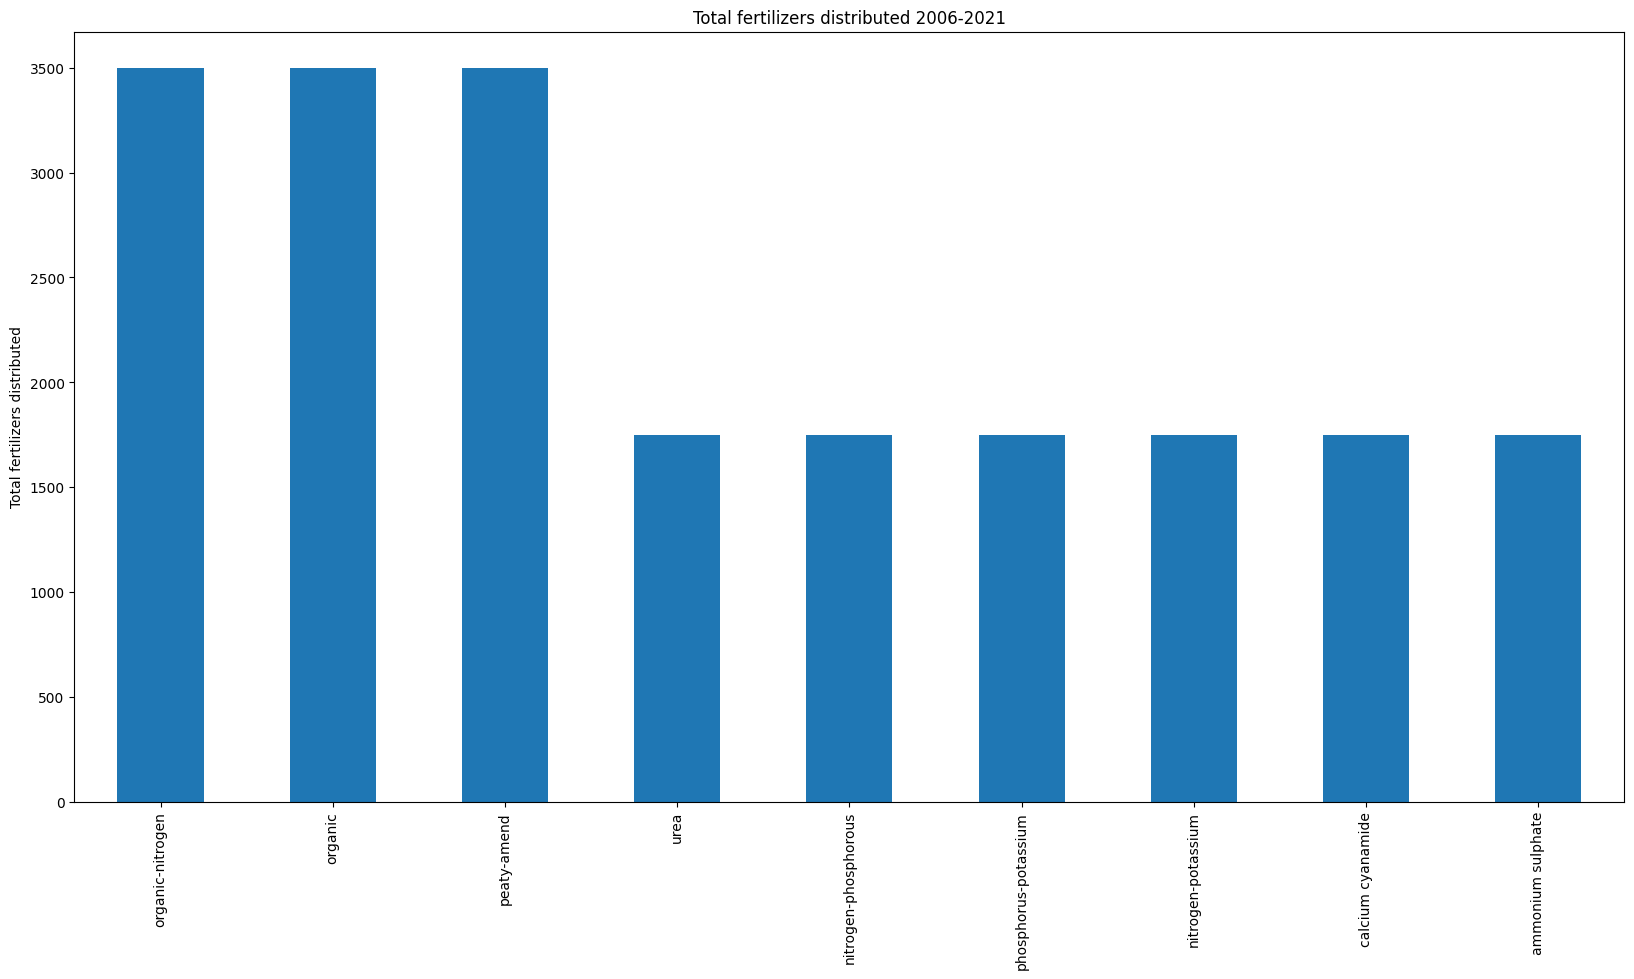

In [81]:
plt.figure(figsize=(20,10))
fertilizer['Type_fertilizer'].value_counts().plot.bar()
plt.title('Total fertilizers distributed 2006-2021')
plt.ylabel('Total fertilizers distributed')
plt.show()

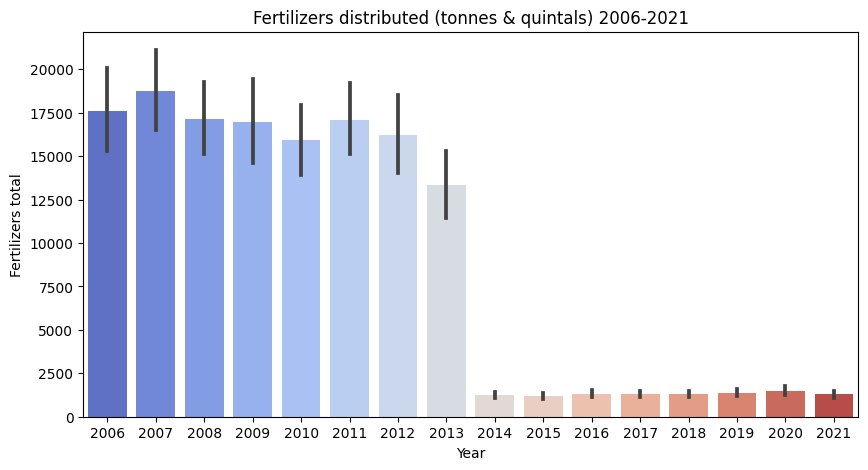

In [82]:
# fertilizer distributed tonnes and quintals
plt.figure(figsize= (10,5))
sns.barplot(x= 'Year', y= 'Fertilizers_tonnes',data = fertilizer, palette='coolwarm')
plt.title('Fertilizers distributed (tonnes & quintals) 2006-2021')
plt.xlabel('Year')
plt.ylabel('Fertilizers total')
plt.show()


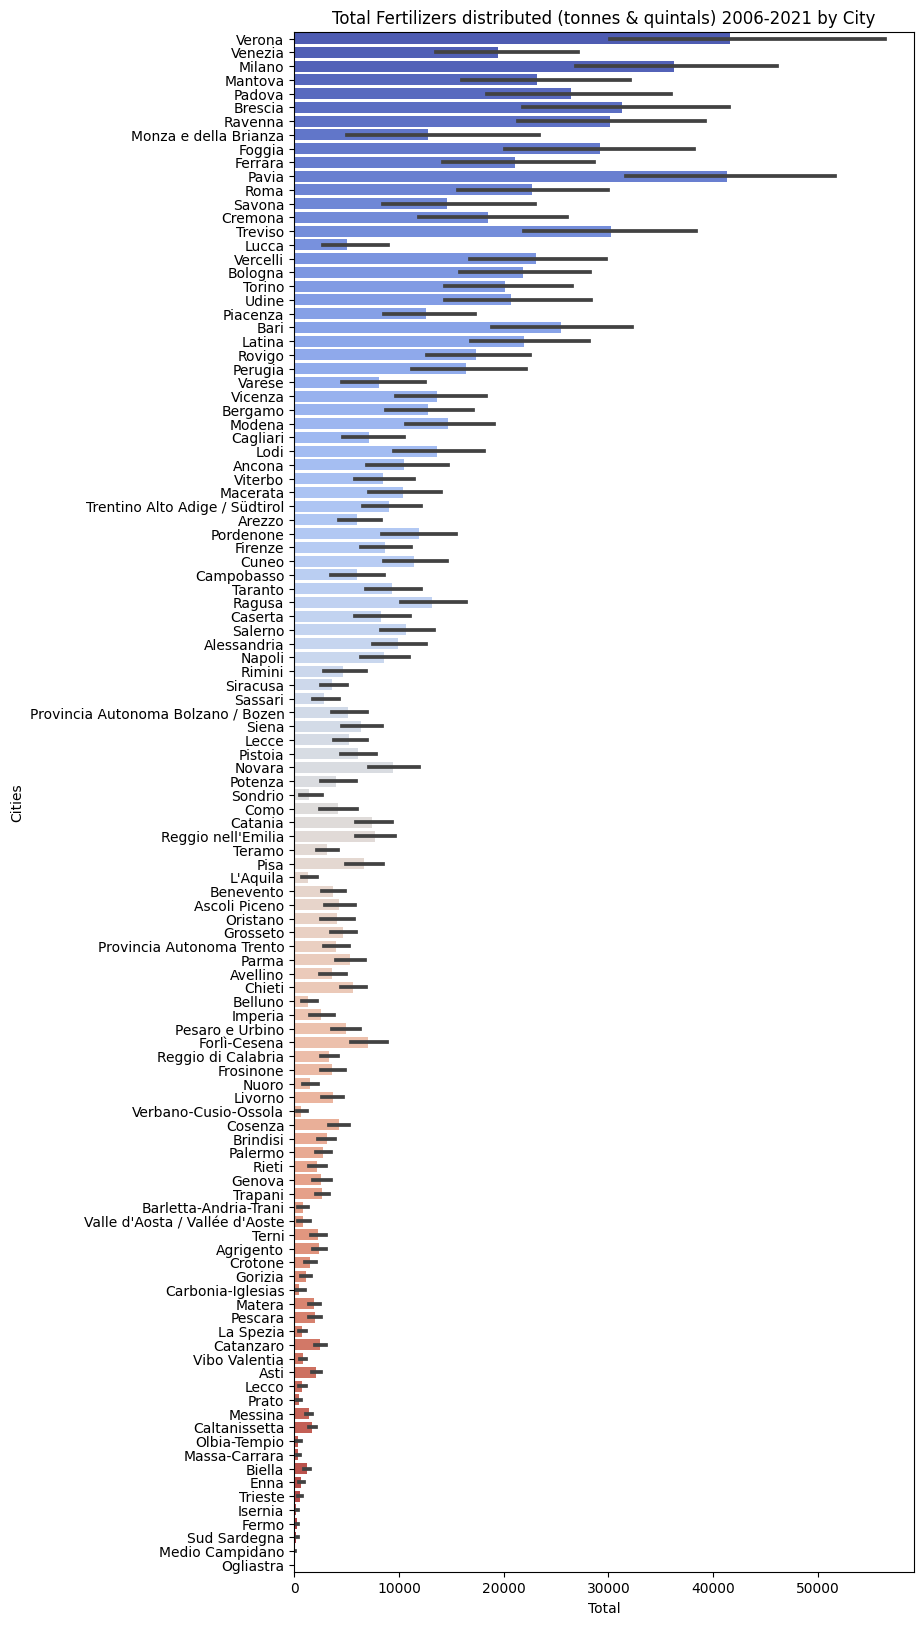

In [83]:
fertilizer= fertilizer.sort_values('Fertilizers_tonnes',ascending=False)

plt.figure(figsize= (8,20))
sns.barplot(x=fertilizer['Fertilizers_tonnes'] ,y= fertilizer ['City'], palette='coolwarm');
plt.title('Total Fertilizers distributed (tonnes & quintals) 2006-2021 by City')
plt.xlabel('Total')
plt.ylabel('Cities')
plt.show()

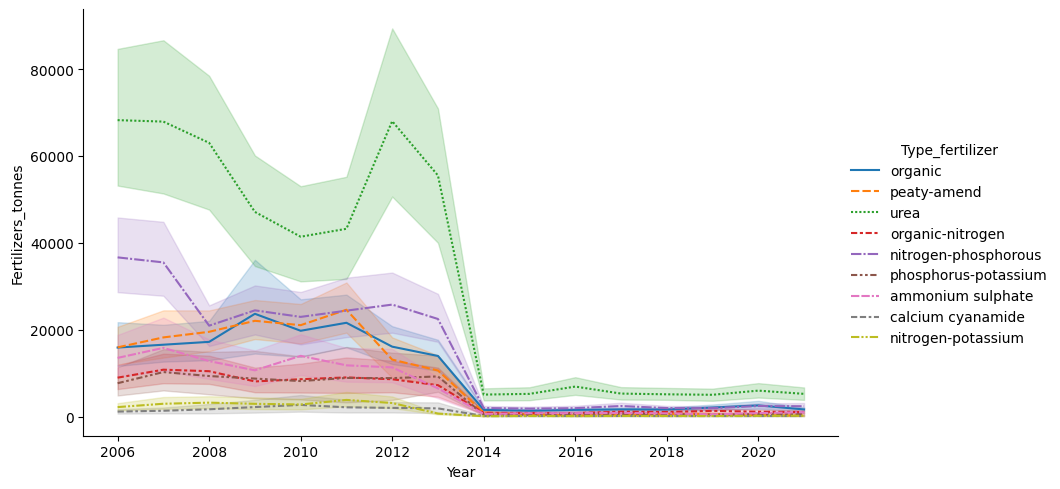

In [84]:
#Fertilizers distributed by year

fertilizer_plot = sns.relplot(kind='line', data=fertilizer, x='Year', y='Fertilizers_tonnes', hue='Type_fertilizer', style='Type_fertilizer', aspect=1.75)


In [85]:
fertilizer.head()

,City,Type_fertilizer,Year,Fertilizers_tonnes
8734,Verona,organic,2009,986716
9983,Venezia,organic,2010,500556
5532,Milano,peaty-amend,2007,460504
7390,Mantova,organic,2009,453752
8731,Verona,organic,2006,392359


### Create new dataframe with the selected type of fertilizers as columns

In [86]:
# Create columns for each type of fertilizer 
fertilizer_pivot = fertilizer.pivot_table(index=['City', 'Year'],aggfunc='sum', columns='Type_fertilizer',values=['Fertilizers_tonnes'])
fertilizer_pivot

Fertilizers_tonnes                                         \
Type_fertilizer  ammonium sulphate calcium cyanamide nitrogen-phosphorous   
City      Year                                                              
Agrigento 2006              1687.0               0.0               4977.0   
          2007              2171.0               0.0               6498.0   
          2008              1400.0               0.0               5213.0   
          2009              1404.0               0.0               3808.0   
          2010              1416.0             140.0               3271.0   
...                            ...               ...                  ...   
Viterbo   2017               153.0               0.0               4732.0   
          2018               149.0               0.0               4376.0   
          2019                70.0               0.0               3964.0   
          2020               176.0               0.0               6145.0   
          2021               152.0               0.0               3946.0   

                                                                          \
Type_fertilizer nitrogen-potassium  organic organic-nitrogen peaty-amend   
City      Year                                                             
Agrigento 2006               277.0  31439.0           7779.0      2966.0   
          2007               491.0  35348.0           6079.0      2949.0   
          2008               614.0  37504.0          14075.0      3506.0   
          2009               468.0  27914.0           8984.0      5678.0   
          2010               440.0  23460.0           9136.0      3082.0   
...                            ...      ...              ...         ...   
Viterbo   2017                66.0   1760.0           2268.0       274.0   
          2018                19.0   1591.0           2106.0       811.0   
          2019               195.0   1251.0           2884.0       427.0   
          2020                98.0   1236.0           2935.0       275.0   
          2021               112.0   1056.0           3337.0       131.0   

                                              
Type_fertilizer phosphorus-potassium    urea  
City      Year                                
Agrigento 2006                2093.0  2100.0  
          2007                2953.0  5100.0  
          2008                4438.0  2736.0  
          2009                3590.0  2716.0  
          2010                3506.0  2962.0  
...                              ...     ...  
Viterbo   2017                 179.0  2859.0  
          2018                  91.0  2863.0  
          2019                  95.0  2413.0  
          2020                 119.0  3578.0  
          2021                 126.0  2054.0  

[1749 rows x 9 columns]

In [87]:
# Drop level
fertilizer_pivot.columns = fertilizer_pivot.columns.droplevel()
fertilizer_pivot

Type_fertilizer  ammonium sulphate  calcium cyanamide  nitrogen-phosphorous  \
City      Year                                                                
Agrigento 2006              1687.0                0.0                4977.0   
          2007              2171.0                0.0                6498.0   
          2008              1400.0                0.0                5213.0   
          2009              1404.0                0.0                3808.0   
          2010              1416.0              140.0                3271.0   
...                            ...                ...                   ...   
Viterbo   2017               153.0                0.0                4732.0   
          2018               149.0                0.0                4376.0   
          2019                70.0                0.0                3964.0   
          2020               176.0                0.0                6145.0   
          2021               152.0                0.0                3946.0   

Type_fertilizer  nitrogen-potassium  organic  organic-nitrogen  peaty-amend  \
City      Year                                                                
Agrigento 2006                277.0  31439.0            7779.0       2966.0   
          2007                491.0  35348.0            6079.0       2949.0   
          2008                614.0  37504.0           14075.0       3506.0   
          2009                468.0  27914.0            8984.0       5678.0   
          2010                440.0  23460.0            9136.0       3082.0   
...                             ...      ...               ...          ...   
Viterbo   2017                 66.0   1760.0            2268.0        274.0   
          2018                 19.0   1591.0            2106.0        811.0   
          2019                195.0   1251.0            2884.0        427.0   
          2020                 98.0   1236.0            2935.0        275.0   
          2021                112.0   1056.0            3337.0        131.0   

Type_fertilizer  phosphorus-potassium    urea  
City      Year                                 
Agrigento 2006                 2093.0  2100.0  
          2007                 2953.0  5100.0  
          2008                 4438.0  2736.0  
          2009                 3590.0  2716.0  
          2010                 3506.0  2962.0  
...                               ...     ...  
Viterbo   2017                  179.0  2859.0  
          2018                   91.0  2863.0  
          2019                   95.0  2413.0  
          2020                  119.0  3578.0  
          2021                  126.0  2054.0  

[1749 rows x 9 columns]

In [88]:
#Rename index
fertilizer_pivot = fertilizer_pivot.rename_axis(None,axis=1)
fertilizer_pivot

ammonium sulphate  calcium cyanamide  nitrogen-phosphorous  \
City      Year                                                               
Agrigento 2006             1687.0                0.0                4977.0   
          2007             2171.0                0.0                6498.0   
          2008             1400.0                0.0                5213.0   
          2009             1404.0                0.0                3808.0   
          2010             1416.0              140.0                3271.0   
...                           ...                ...                   ...   
Viterbo   2017              153.0                0.0                4732.0   
          2018              149.0                0.0                4376.0   
          2019               70.0                0.0                3964.0   
          2020              176.0                0.0                6145.0   
          2021              152.0                0.0                3946.0   

                nitrogen-potassium  organic  organic-nitrogen  peaty-amend  \
City      Year                                                               
Agrigento 2006               277.0  31439.0            7779.0       2966.0   
          2007               491.0  35348.0            6079.0       2949.0   
          2008               614.0  37504.0           14075.0       3506.0   
          2009               468.0  27914.0            8984.0       5678.0   
          2010               440.0  23460.0            9136.0       3082.0   
...                            ...      ...               ...          ...   
Viterbo   2017                66.0   1760.0            2268.0        274.0   
          2018                19.0   1591.0            2106.0        811.0   
          2019               195.0   1251.0            2884.0        427.0   
          2020                98.0   1236.0            2935.0        275.0   
          2021               112.0   1056.0            3337.0        131.0   

                phosphorus-potassium    urea  
City      Year                                
Agrigento 2006                2093.0  2100.0  
          2007                2953.0  5100.0  
          2008                4438.0  2736.0  
          2009                3590.0  2716.0  
          2010                3506.0  2962.0  
...                              ...     ...  
Viterbo   2017                 179.0  2859.0  
          2018                  91.0  2863.0  
          2019                  95.0  2413.0  
          2020                 119.0  3578.0  
          2021                 126.0  2054.0  

[1749 rows x 9 columns]

In [89]:
# Reset index
fertilizer_pivot = fertilizer_pivot.reset_index()
fertilizer_pivot

,City,Year,ammonium sulphate,calcium cyanamide,nitrogen-phosphorous,nitrogen-potassium,organic,organic-nitrogen,peaty-amend,phosphorus-potassium,urea
0,Agrigento,2006,1687.0,0.0,4977.0,277.0,31439.0,7779.0,2966.0,2093.0,2100.0
1,Agrigento,2007,2171.0,0.0,6498.0,491.0,35348.0,6079.0,2949.0,2953.0,5100.0
2,Agrigento,2008,1400.0,0.0,5213.0,614.0,37504.0,14075.0,3506.0,4438.0,2736.0
3,Agrigento,2009,1404.0,0.0,3808.0,468.0,27914.0,8984.0,5678.0,3590.0,2716.0
4,Agrigento,2010,1416.0,140.0,3271.0,440.0,23460.0,9136.0,3082.0,3506.0,2962.0
...,...,...,...,...,...,...,...,...,...,...,...
1744,Viterbo,2017,153.0,0.0,4732.0,66.0,1760.0,2268.0,274.0,179.0,2859.0
1745,Viterbo,2018,149.0,0.0,4376.0,19.0,1591.0,2106.0,811.0,91.0,2863.0
1746,Viterbo,2019,70.0,0.0,3964.0,195.0,1251.0,2884.0,427.0,95.0,2413.0
1747,Viterbo,2020,176.0,0.0,6145.0,98.0,1236.0,2935.0,275.0,119.0,3578.0


#### Join crop and fertilizers datasets

In [90]:
# Join both datasets 
it_crop_ferlizer = pd.merge(industrial_crop_top10_pivot, fertilizer_pivot, on=['Year', 'City'], how='left').fillna(0)
it_crop_ferlizer

,City,Year,basil-ghouse,flax,hemp,parsley-field,parsley-ghouse,rape,soya beans,sunflower,...,valerian-ghouse,ammonium sulphate,calcium cyanamide,nitrogen-phosphorous,nitrogen-potassium,organic,organic-nitrogen,peaty-amend,phosphorus-potassium,urea
0,Agrigento,2006,0.0,0.0,0.0,50.0,0.0,0.0,0.0,0.0,...,0.0,1687.0,0.0,4977.0,277.0,31439.0,7779.0,2966.0,2093.0,2100.0
1,Agrigento,2007,0.0,0.0,0.0,90.0,0.0,0.0,0.0,0.0,...,0.0,2171.0,0.0,6498.0,491.0,35348.0,6079.0,2949.0,2953.0,5100.0
2,Agrigento,2008,0.0,0.0,0.0,88.0,0.0,0.0,0.0,0.0,...,0.0,1400.0,0.0,5213.0,614.0,37504.0,14075.0,3506.0,4438.0,2736.0
3,Agrigento,2009,0.0,0.0,0.0,84.0,0.0,0.0,0.0,0.0,...,0.0,1404.0,0.0,3808.0,468.0,27914.0,8984.0,5678.0,3590.0,2716.0
4,Agrigento,2010,0.0,0.0,0.0,97.0,0.0,0.0,0.0,0.0,...,0.0,1416.0,140.0,3271.0,440.0,23460.0,9136.0,3082.0,3506.0,2962.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1634,Viterbo,2018,0.0,1000.0,480.0,0.0,0.0,420.0,0.0,18000.0,...,0.0,149.0,0.0,4376.0,19.0,1591.0,2106.0,811.0,91.0,2863.0
1635,Viterbo,2019,0.0,1150.0,165.0,0.0,0.0,600.0,0.0,18000.0,...,0.0,70.0,0.0,3964.0,195.0,1251.0,2884.0,427.0,95.0,2413.0
1636,Viterbo,2020,0.0,1150.0,215.0,0.0,0.0,550.0,0.0,16900.0,...,0.0,176.0,0.0,6145.0,98.0,1236.0,2935.0,275.0,119.0,3578.0
1637,Viterbo,2021,0.0,1140.0,215.0,0.0,0.0,290.0,0.0,16760.0,...,0.0,152.0,0.0,3946.0,112.0,1056.0,3337.0,131.0,126.0,2054.0


### Correlation

In [91]:

crop = it_crop_ferlizer.City.astype('category')
targets = dict(enumerate(crop.cat.categories))
it_crop_ferlizer['target']=crop.cat.codes

#y = it_crop_ferliser.Type_crop
cor_selected = it_crop_ferlizer[['valerian-ghouse', 'basil-ghouse', 'sunflower', 'rape', 
                                  'soya beans', 'hemp', 'parsley-field','parsley-ghouse',
                                  'tobacco', 'flax','calcium cyanamide','nitrogen-potassium',
                                 'organic', 'phosphorus-potassium','urea']] 


<AxesSubplot: title={'center': 'Correlation'}>

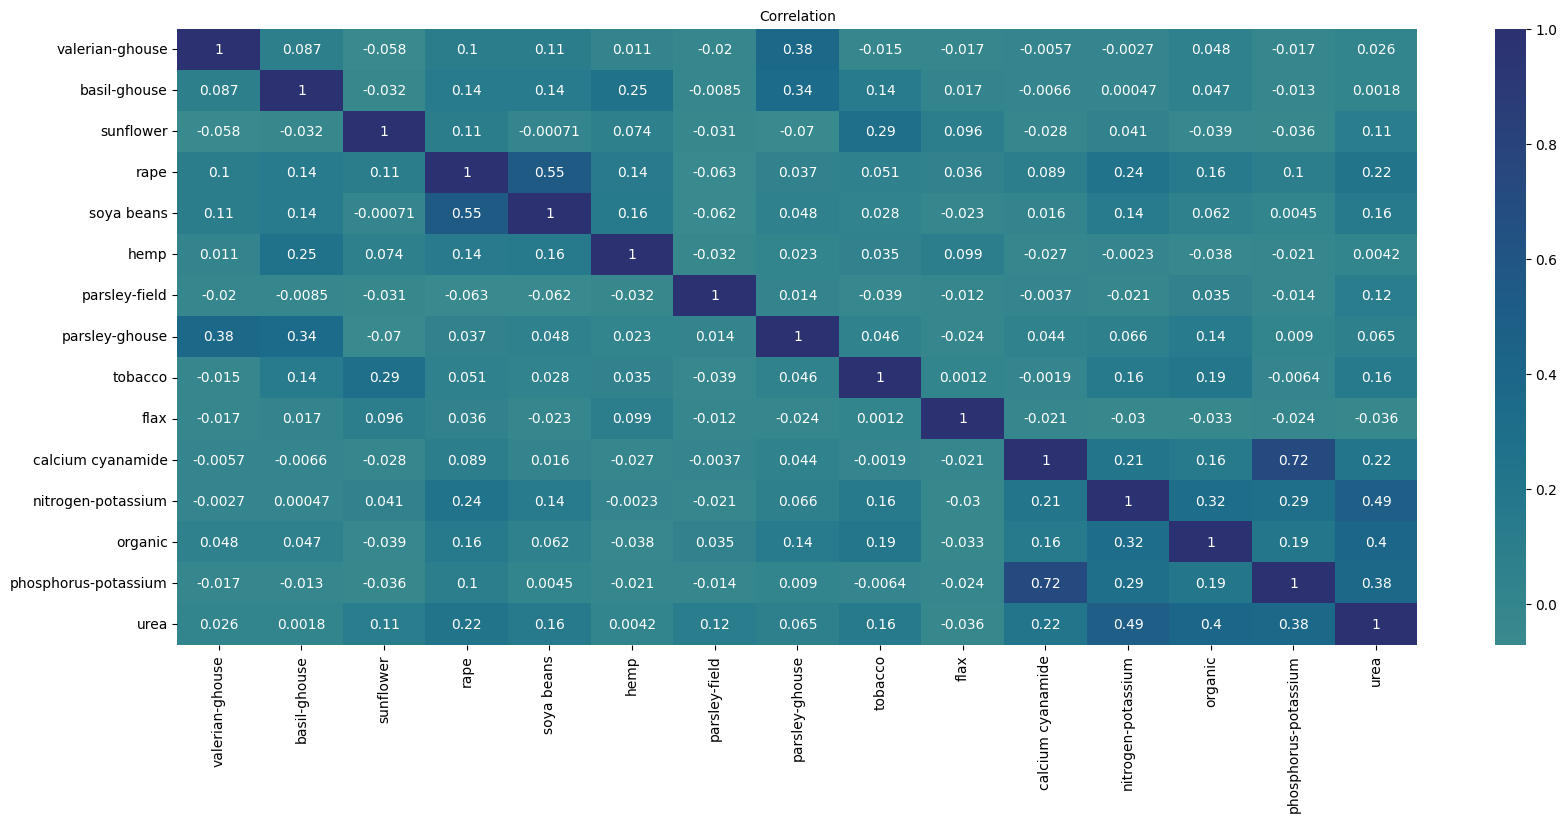

In [92]:
plt.figure(figsize=(20,8))
plt.title('Correlation', size=10)
sns.heatmap(cor_selected.corr(), cmap='crest', center=0, annot=True)

### Correlation analysis of industrial crop production in Italy 

* Valerian in greenhouse has low correlation with fertilizer and other industrial crops.

* Sunflower has low correlation with fertilizer and other industrial crops.

* Soya beans has high correlation with Rape.

* Hemp has low correlation Basil greenhouse, Soya and Rape.

* Basil has high correlation with Pasley in greenhouses, Hemp, Soya and Rape.

* Tobacco and Flax have low correlation with fertilizers and other crops.

* There is also hight correlation between urea, phosphorus and potassium with nitrogen fertilizer.


### Calculating Variance Inflation Factor (VIF) for all given features

In [94]:
# Function to compute the VIF
def compute_vif(selected_features):
    
    y = cor_selected [selected_features]
    # the calculation of variance inflation requires a constant
    y['intercept'] = 1
    
    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Feature"] = y.columns
    vif["VIF"] = [variance_inflation_factor(y.values, i) for i in range(y.shape[1])]
    vif = vif[vif['Feature']!='intercept']
    return vif

In [95]:
# Features selection
selected_features = ['valerian-ghouse', 'basil-ghouse', 'sunflower', 'rape', 
                      'soya beans', 'hemp', 'parsley-field','parsley-ghouse',
                      'tobacco', 'flax','calcium cyanamide','nitrogen-potassium',
                      'organic', 'phosphorus-potassium','urea']

# compute vif 
compute_vif(selected_features).sort_values('VIF', ascending=False)


,Feature,VIF
13,phosphorus-potassium,2.395628
10,calcium cyanamide,2.123061
14,urea,1.692894
3,rape,1.564920
4,soya beans,1.481865
11,nitrogen-potassium,1.428823
7,parsley-ghouse,1.351751
12,organic,1.300784
1,basil-ghouse,1.270652
0,valerian-ghouse,1.190918


Modelling 

# References


http://dati.istat.it

https://maps.princeton.edu/catalog/stanford-mn871sp9778

https://www.crea.gov.it/documents/68457/0/ITACONTA+2020_ENG+DEF+xweb+%281%29.pdf/95c6b30a-1e18-8e94-d4ac-ce884aef76e8?t=1619527317576

https://seaborn.pydata.org/generated/seaborn.relplot.html